Souna Niang

Ousmane Kontao

Oumar Talibe BA

# TP06 Dask Array
# Distance de Levenstein

La distance de Levenshtein est une métrique permettant de mesurer la différence entre deux séquences de caractères. Cette distance correspond au nombre minimal d'opérations élémentaires (insertion, suppression ou substitution de caractères) nécessaires pour transformer une séquence en une autre.

Par exemple, la distance entre `sitting` et `kitten` est de 3 (2 substitutions, 1 suppression).

Formellement, la distance peut être définie de manière récursive selon la définition suivante où pour une chaîne de caractères $s$, $|s|$ représente sa longueur et $s-1$ désigne la chaîne $s$ sans son premier caractère.
$$
\qquad\operatorname{lev}(a,b) = 
\begin{cases}
  \max(|a|,|b|) & \text{ si } \min(|a|,|b|)=0, \\
  \operatorname{lev}(a-1,b-1) & \text{ si } a[0]=b[0], \\
  1 + \min \begin{cases}
          \operatorname{lev}(a-1,b)\\
          \operatorname{lev}(a,b-1)\\
          \operatorname{lev}(a-1,b-1)
       \end{cases} & \text{ sinon.}
\end{cases}
$$

À partir de cette définition, il en résulte un algorithme itératif dynamique naïf permettant de calculer la distance de Levenshtein entre deux séquences en remplissant une matrice de coûts (matrice d'édition).

L’objectif de cet exercice est d’établir un algorithme distribué du calcul de la distance de Levenshtein et, si possible, de le mettre en oeuvre avec Dask

In [48]:
import numpy as np

In [49]:
from numba import njit

In [50]:
def initialize_matrix(s1, s2):
    """Initialisation de la matrice d'édition avec les bords (insertions/suppressions)."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = np.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = np.arange(n+1)  # Première ligne : Insertions

    return dp

In [51]:
def fill_matrix(dp, s1, s2):
    """Remplissage la matrice de Levenshtein (approche dynamique)"""
    m, n = len(s1), len(s2)

    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i, j] = min(
                dp[i-1, j] + 1,      # Suppression
                dp[i, j-1] + 1,      # Insertion
                dp[i-1, j-1] + cost  # Substitution
            )

In [52]:
def levenshtein_numpy(s1, s2):
    """Calcul de la distance levenshtein."""
    dp = initialize_matrix(s1, s2)  # Initialisation de la matrice
    fill_matrix(dp, s1, s2)         # Remplissage de la matrice

    return dp[len(s1), len(s2)]     # Retourne la distance finale

### Test

In [53]:
s1 = "GATTACA"
s2 = "GCATGCU"
print(levenshtein_numpy(s1, s2))  

4


## 1. Version naïve.
1. Tester l’algorithme sur différentes séquences en augmentant la taille des séquences et relever les temps de restitution.

In [54]:
#TODO
import time
import random
import matplotlib.pyplot as plt


def generate_random_sequence(length, alphabet="ACGT"):
    return ''.join(random.choice(alphabet) for _ in range(length))


sequence_lengths = [10, 100, 900, 1200, 2000, 5000, 10000]  # Tailles des séquences
sequence_pairs = [(generate_random_sequence(length), generate_random_sequence(length)) for length in sequence_lengths]

times = []
for s1, s2 in sequence_pairs:
    start = time.time()
    levenshtein_numpy(s1, s2)
    end = time.time()
    times.append(end - start)



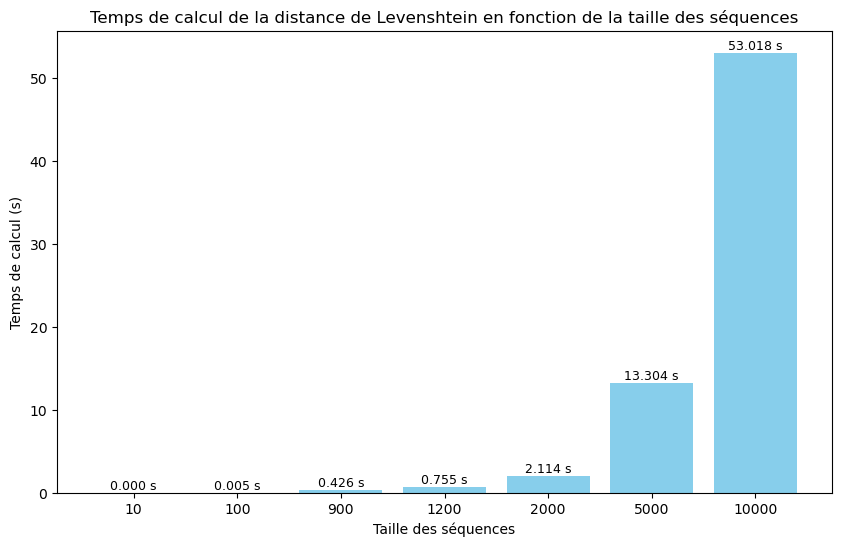

In [55]:
plt.figure(figsize=(10, 6))
bars = plt.bar([str(seq_legth) for seq_legth in sequence_lengths], times, color='skyblue')
plt.xlabel('Taille des séquences')
plt.ylabel('Temps de calcul (s)')
plt.title('Temps de calcul de la distance de Levenshtein en fonction de la taille des séquences')

for bar, time_val in zip(bars, times):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Position x du texte (centre de la barre)
        height + 0.001,  # Position y du texte (légèrement au-dessus de la barre)
        f'{time_val:.3f} s',  # Texte à afficher (temps de calcul)
        ha='center',  # Alignement horizontal au centre
        va='bottom',  # Alignement vertical en bas
        fontsize=9,  # Taille de la police
    )


# Afficher le diagramme
plt.show()

2. Sur la base du code existant écrire un version utilisant des dask array. 
Tester sur de petites séquences, observer le graphe des tâches et relever les temps de restitution.

In [56]:
#TODO
import dask.array as da
from dask.diagnostics import ProgressBar


def initialize_matrix_dask(s1, s2):
    """Initialisation de la matrice d'édition avec Dask."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale avec Dask
    dp = da.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = da.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = da.arange(n+1)  # Première ligne : Insertions
    return dp

def fill_matrix_dask(dp, s1, s2):
    """Remplissage de la matrice de Levenshtein avec Dask."""
    m, n = len(s1), len(s2)

    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i, j] = da.minimum(
                dp[i-1, j] + 1,      # Suppression
                dp[i, j-1] + 1,      # Insertion
                dp[i-1, j-1] + cost  # Substitution
            )

def levenshtein_dask(s1, s2):
    """Calcul de la distance de Levenshtein avec Dask."""
    dp = initialize_matrix_dask(s1, s2)  # Initialisation de la matrice
    fill_matrix_dask(dp, s1, s2)         # Remplissage de la matrice

    # Calculer la valeur finale (distance de Levenshtein)
    final_distance = dp[len(s1), len(s2)]
    return final_distance


s1 = "kitten"
s2 = "sitting"

# Mesurer le temps d'exécution
start_time = time.time()
distance = levenshtein_dask(s1, s2)
end_time = time.time()

# Afficher les résultats
print(f"Distance de Levenshtein entre '{s1}' et '{s2}': {distance}")
print(f"Temps d'exécution: {end_time - start_time:.6f} secondes")

# Visualiser le graphe des tâches
dp = initialize_matrix_dask(s1, s2)
fill_matrix_dask(dp, s1, s2)
dp.visualize(filename='levenshtein_dask_graph.png')  # 

Distance de Levenshtein entre 'kitten' et 'sitting': dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>
Temps d'exécution: 0.179276 secondes


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.77811 to fit


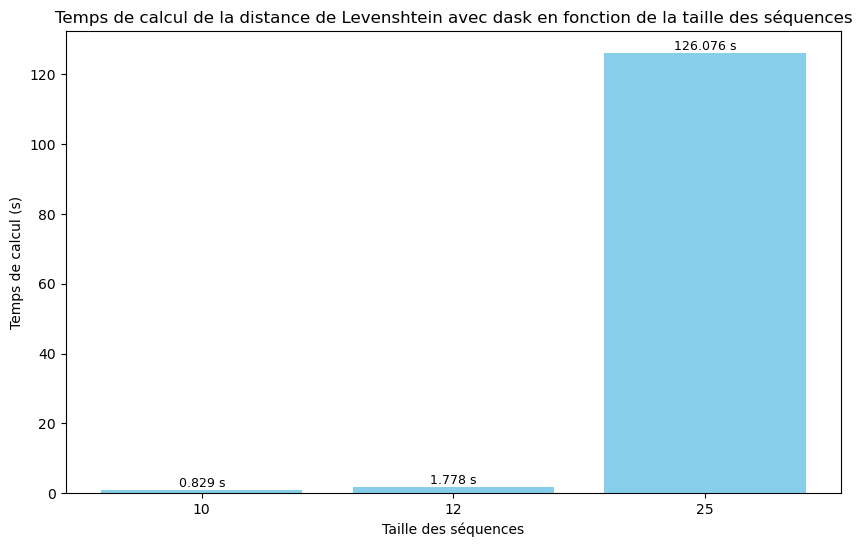

In [57]:
sequence_lengths = [10, 12, 25]  # Tailles des séquences
sequence_pairs = [(generate_random_sequence(length), generate_random_sequence(length)) for length in sequence_lengths]

times = []
for s1, s2 in sequence_pairs:
    start = time.time()
    levenshtein_dask(s1, s2)
    end = time.time()
    times.append(end - start)
    
plt.figure(figsize=(10, 6))
bars = plt.bar([str(seq_legth) for seq_legth in sequence_lengths], times, color='skyblue')
plt.xlabel('Taille des séquences')
plt.ylabel('Temps de calcul (s)')
plt.title('Temps de calcul de la distance de Levenshtein avec dask en fonction de la taille des séquences')

for bar, time_val in zip(bars, times):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Position x du texte (centre de la barre)
        height + 0.001,  # Position y du texte (légèrement au-dessus de la barre)
        f'{time_val:.3f} s',  # Texte à afficher (temps de calcul)
        ha='center',  # Alignement horizontal au centre
        va='bottom',  # Alignement vertical en bas
        fontsize=9,  # Taille de la police
    )


# Afficher le diagramme
plt.show()

## 2 Optimisations
1. Sur la base de la version numpy, écrire un algorithme non parallèle où la matrice principale est remplie en la parcourant par bloc de taille fixe (par exemple 100 $\times$ 100) : on remplit le premier bloc puis on passe au suivant ligne par ligne.

In [58]:
#TODO

def initialize_matrix(s1, s2):
    """Initialisation de la matrice d'édition avec les bords (insertions/suppressions)."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = np.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = np.arange(n+1)  # Première ligne : Insertions

    return dp

def fill_matrix_by_blocks(dp, s1, s2, block_size=25):
    """Remplissage de la matrice de Levenshtein par blocs."""
    m, n = len(s1), len(s2)

    # Parcourir la matrice par blocs
    for i_start in range(1, m+1, block_size):
        for j_start in range(1, n+1, block_size):
            # Définir les limites du bloc
            i_end = min(i_start + block_size, m+1)
            j_end = min(j_start + block_size, n+1)

            # Remplir le bloc
            for i in range(i_start, i_end):
                for j in range(j_start, j_end):
                    cost = 0 if s1[i-1] == s2[j-1] else 1
                    dp[i, j] = min(
                        dp[i-1, j] + 1,      # Suppression
                        dp[i, j-1] + 1,      # Insertion
                        dp[i-1, j-1] + cost  # Substitution
                    )

def levenshtein_block(s1, s2, block_size=100):
    """Calcul de la distance de Levenshtein en remplissant la matrice par blocs."""
    dp = initialize_matrix(s1, s2)  # Initialisation de la matrice
    fill_matrix_by_blocks(dp, s1, s2, block_size)  # Remplissage par blocs

    return dp[len(s1), len(s2)]  # Retourne la distance finale


In [59]:
# Tester l'algorithme
s1 = "kitten"
s2 = "sitting"

# Mesurer le temps d'exécution
import time
start_time = time.time()
distance = levenshtein_block(s1, s2, block_size=2)  # Taille de bloc réduite pour l'exemple
end_time = time.time()

# Afficher les résultats
print(f"Distance de Levenshtein entre '{s1}' et '{s2}': {distance}")
print(f"Temps d'exécution: {end_time - start_time:.6f} secondes")

Distance de Levenshtein entre 'kitten' et 'sitting': 3
Temps d'exécution: 0.000520 secondes


2. Relever les temps de restitution.

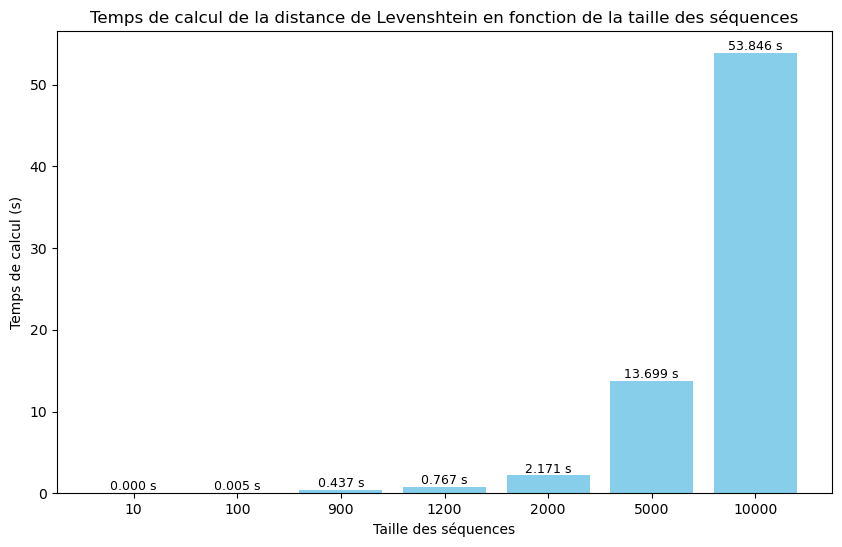

In [60]:
#TODO
sequence_lengths = [10, 100, 900, 1200, 2000, 5000, 10000]  # Tailles des séquences
sequence_pairs = [(generate_random_sequence(length), generate_random_sequence(length)) for length in sequence_lengths]

times = []
for s1, s2 in sequence_pairs:
    start = time.time()
    levenshtein_block(s1, s2, block_size=100)
    end = time.time()
    times.append(end - start)


plt.figure(figsize=(10, 6))
bars = plt.bar([str(seq_legth) for seq_legth in sequence_lengths], times, color='skyblue')
plt.xlabel('Taille des séquences')
plt.ylabel('Temps de calcul (s)')
plt.title('Temps de calcul de la distance de Levenshtein en fonction de la taille des séquences')

for bar, time_val in zip(bars, times):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Position x du texte (centre de la barre)
        height + 0.001,  # Position y du texte (légèrement au-dessus de la barre)
        f'{time_val:.3f} s',  # Texte à afficher (temps de calcul)
        ha='center',  # Alignement horizontal au centre
        va='bottom',  # Alignement vertical en bas
        fontsize=9,  # Taille de la police
    )


# Afficher le diagramme
plt.show()

3. Sur la base de cette version établir un algorithme parallèle et tenter de le mettre en oeuvre à l’aide de Dask array, pour cela regarder les méthodes `map_blocks` et `map_overlap`.

In [61]:
#TODO

def initialize_matrix_dask(s1, s2, block_size=100):
    """Initialisation de la matrice d'édition avec Dask."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale avec Dask
    dp = da.zeros((m+1, n+1), dtype=int, chunks=(block_size, block_size))

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = da.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = da.arange(n+1)  # Première ligne : Insertions

    return dp

def fill_block(block, s1, s2, i_start, j_start):
    """Remplir un bloc de la matrice de Levenshtein."""
    m, n = block.shape
    for i in range(1, m):
        for j in range(1, n):
            # Calculer les indices globaux
            global_i = i_start + i
            global_j = j_start + j

            # Vérifier les limites des séquences
            if global_i > len(s1) or global_j > len(s2):
                continue

            # Calculer le coût de substitution
            cost = 0 if s1[global_i-1] == s2[global_j-1] else 1

            # Mettre à jour la cellule
            block[i, j] = min(
                block[i-1, j] + 1,      # Suppression
                block[i, j-1] + 1,      # Insertion
                block[i-1, j-1] + cost  # Substitution
            )
    return block


def levenshtein_dask(s1, s2, block_size=100):
    """Calcul de la distance de Levenshtein avec Dask."""
    dp = initialize_matrix_dask(s1, s2, block_size)  # Initialisation de la matrice

    # Remplir la matrice par blocs avec map_overlap
    dp = da.map_overlap(
        fill_block,
        dp,
        depth=(1, 1),  # Chevauchement de 1 cellule pour gérer les dépendances
        boundary="none",  # Pas de remplissage aux bords
        dtype=int,
        s1=s1,
        s2=s2,
    )

    # Calculer la valeur finale (distance de Levenshtein)
    with ProgressBar():
        final_distance = dp[len(s1), len(s2)]

    return final_distance

In [62]:

# Tester l'algorithme
s1 = "kitten"
s2 = "sitting"

# Mesurer le temps d'exécution
import time
start_time = time.time()
distance = levenshtein_dask(s1, s2, block_size=2)  # Taille de bloc réduite pour l'exemple
end_time = time.time()

# Afficher les résultats
print(f"Distance de Levenshtein entre '{s1}' et '{s2}': {distance}")
print(f"Temps d'exécution: {end_time - start_time:.6f} secondes")

Distance de Levenshtein entre 'kitten' et 'sitting': dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>
Temps d'exécution: 0.004745 secondes


4. Relever les temps de restitution

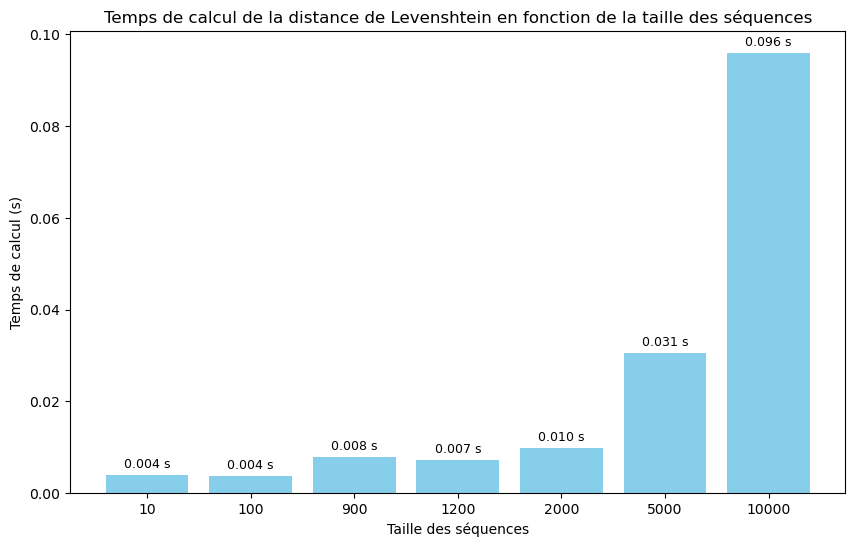

In [63]:
#TODO

sequence_lengths = [10, 100, 900, 1200, 2000, 5000, 10000]  # Tailles des séquences
sequence_pairs = [(generate_random_sequence(length), generate_random_sequence(length)) for length in sequence_lengths]

times = []
for s1, s2 in sequence_pairs:
	start = time.time()
	levenshtein_dask(s1, s2, block_size=100)
	end = time.time()
	times.append(end - start)



plt.figure(figsize=(10, 6))
bars = plt.bar([str(seq_legth) for seq_legth in sequence_lengths], times, color='skyblue')
plt.xlabel('Taille des séquences')
plt.ylabel('Temps de calcul (s)')
plt.title('Temps de calcul de la distance de Levenshtein en fonction de la taille des séquences')

for bar, time_val in zip(bars, times):
	height = bar.get_height()
	plt.text(
		bar.get_x() + bar.get_width() / 2,  # Position x du texte (centre de la barre)
		height + 0.001,  # Position y du texte (légèrement au-dessus de la barre)
		f'{time_val:.3f} s',  # Texte à afficher (temps de calcul)
		ha='center',  # Alignement horizontal au centre
		va='bottom',  # Alignement vertical en bas
		fontsize=9,  # Taille de la police
	)

# Afficher le diagramme
plt.show()
